# <div align="center"> Аналитика в Яндекс.Афише </div>

Задача: помочь маркетологам оптимизировать маркетинговые затраты. У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года.<p>
<u>Необходимо изучить:</u><p>
<li>как люди пользуются продуктом,
<li>когда они начинают покупать,
<li>сколько денег приносит каждый клиент
<li>когда клиент окупается.

## Шаг 1. Загрузить данные и подготовить их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats as st
import seaborn as sns
sns.set_style("ticks")

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M")
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d %H:%M")
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [8]:
visits.name = 'visits'
orders.name = 'orders'
costs.name = 'costs'

In [9]:
for i in [visits, orders, costs]:
    if i.duplicated().sum() > 0:
        print('Дубликатов в таблице',i.name,":",i.duplicated().sum())
        i = i.drop_duplicates().reset_index(drop = True)
        print('Дубликаты удалены')
    else:
        print('Дубликаты в таблице', i.name,'отсутствуют')

Дубликаты в таблице visits отсутствуют
Дубликаты в таблице orders отсутствуют
Дубликаты в таблице costs отсутствуют


Были загружены таблица visits с данными о визитах, таблица orders с данными по заказам и таблица costs с данными по расходам маркетинга. Был исправлен тип переменных с датой, таблицы проверены на пустые значения и дубликаты.

In [10]:
visits['start_ts'].min()

Timestamp('2017-06-01 00:01:00')

In [11]:
visits['end_ts'].max()

Timestamp('2018-06-01 01:26:00')

In [12]:
orders['buy_ts'].min()

Timestamp('2017-06-01 00:10:00')

In [13]:
orders['buy_ts'].max()

Timestamp('2018-06-01 00:02:00')

In [14]:
visits = visits[visits['end_ts'] < '2018-06-01 00:00:00']
orders = orders[orders['buy_ts'] < '2018-06-01 00:00:00']

Данные содержат сведения о посещениях сайта и заказов с него с 1 июня 2017 года до 1 июня 2018 года. В базу попало только небольшое количество сведений в ночь с 31 мая на 1 июня 2018 года, полноценно июнь при этом не представлен, поэтому считаю правильным решением исключить эти данные из анализа.

## Шаг 2. Построить отчёты и посчитать метрики

### <i> Продукт. Сколько людей пользуются в день, неделю, месяц? </i>

In [15]:
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['day'] = visits['start_ts'].dt.date
visits['day_r'] = visits['start_ts'].dt.day
visits['month_r'] = visits['start_ts'].astype('datetime64[M]')
visits['week_r'] = visits['start_ts'].astype('datetime64[W]')

In [16]:
# Рассчитаем mau по устройствам
visits_mau = visits.groupby(['month_r', 'device']).agg({'uid': 'nunique'}).reset_index()
visits_mau.columns=['month_r', 'device','mau']
# Объединим показатели с основной таблицей
visits = visits.merge(visits_mau,on=['month_r', 'device'])

# Рассчитаем wau по устройствам
visits_wau = visits.groupby(['week_r', 'device']).agg({'uid': 'nunique'}).reset_index()
visits_wau.columns=['week_r','device', 'wau']
# Объединим показатели с основной таблицей
visits = visits.merge(visits_wau,on=['week_r', 'device'])

# Рассчитаем dau по устройствам
visits_dau = visits.groupby(['day', 'device']).agg({'uid': 'nunique'}).reset_index()
visits_dau.columns=['day', 'device', 'dau']
# Объединим показатели с основной таблицей
visits = visits.merge(visits_dau,on=['day','device'])

# Рассчитаем sticky_wau по устройствам
visits_sticky_wau = (visits.groupby(['week_r', 'device']).agg({'dau':'mean'}).reset_index()).merge(
                                                                        visits_wau, on=['week_r', 'device'])
visits_sticky_wau['sticky_wau'] = visits_sticky_wau['dau'] / visits_sticky_wau['wau'] * 100
# Объединим показатели с основной таблицей
visits = visits.merge(visits_sticky_wau[['week_r', 'device', 'sticky_wau']],on=['week_r', 'device'])

# Рассчитаем sticky_mau по устройствам
visits_sticky_mau = (visits.groupby(['month_r', 'device']).agg({'dau':'mean'}).reset_index()).merge(
                                                                        visits_mau, on=['month_r', 'device'])
visits_sticky_mau['sticky_mau'] = visits_sticky_mau['dau'] / visits_sticky_mau['mau'] * 100
# Объединим показатели с основной таблицей
visits = visits.merge(visits_sticky_mau[['month_r', 'device','sticky_mau']],on=['month_r', 'device'])

In [17]:
print('Динамика метрик посещаемости')
visits.pivot_table(['mau', 'wau','dau','sticky_wau', 'sticky_mau'], index=['month_r'], aggfunc='mean')

Динамика метрик посещаемости


,dau,mau,sticky_mau,sticky_wau,wau
month_r,,,,,
2017-06-01,349.978310,8226.823569,4.194668,16.476633,2097.896395
2017-07-01,361.935270,8524.654700,4.207040,16.306380,2188.798744
2017-08-01,292.884082,7274.742320,3.970658,16.034385,1802.384605
2017-09-01,473.032668,11363.422136,4.111795,15.920698,2982.780064
2017-10-01,695.178508,17838.997652,3.862603,15.731298,4380.374456
2017-11-01,942.546044,20536.401533,4.530466,16.880825,5438.805954
2017-12-01,792.471215,19537.066503,4.013379,16.140972,4883.179001
2018-01-01,675.439644,17093.483635,3.927228,15.965170,4220.088362
2018-02-01,756.805793,17317.092894,4.319002,15.969406,4700.048572


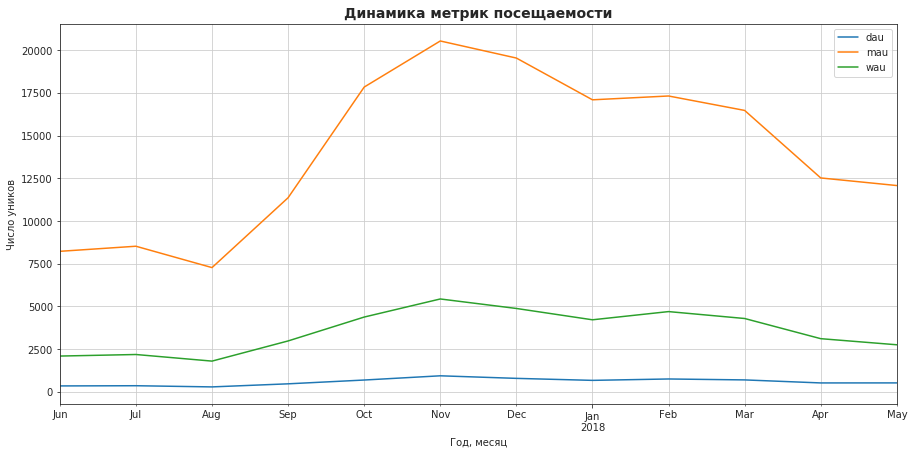

In [18]:
# Построим общий график без распределения по устройствам
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['xtick.minor.visible'] = True

#sns.set_style("ticks")
visits.pivot_table(['mau', 'wau','dau'], index=['month_r'], aggfunc='mean').plot(figsize=(15,7))
plt.title('Динамика метрик посещаемости', weight='bold').set_fontsize('14')
plt.xlabel('Год, месяц')
plt.ylabel('Число уников')
plt.grid(True)
plt.show()

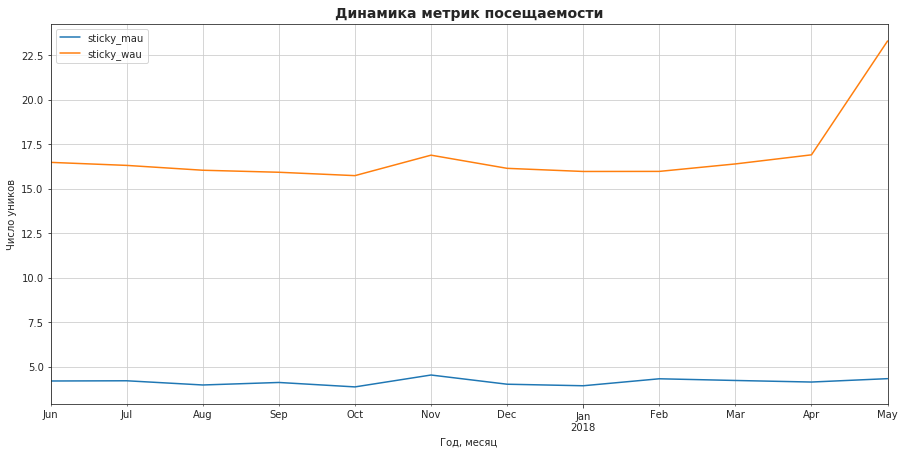

In [19]:
# Построим общий график без распределения по устройствам
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['xtick.minor.visible'] = True

#sns.set_style("ticks")
visits.pivot_table(['sticky_wau', 'sticky_mau'], index=['month_r'], aggfunc='mean').plot(figsize=(15,7))
plt.title('Динамика метрик посещаемости', weight='bold').set_fontsize('14')
plt.xlabel('Год, месяц')
plt.ylabel('Число уников')
plt.grid(True)
plt.show()

В динамике метрики посещаемости (dau, wau, mau) с июня по август были относительно стабильны, далее демонстрировали резкий рост, достигали вершины в ноябре и к маю медленно снижались. Так, число уникальных полизователей, заходивших на сайт Яндекс.Афиши в июне 2017 составило 8 тыс., к ноябрю равнялось уже 20 тыс., к маю снизилось до 12 тыс. Для wau показатели в эти месяцы были 2.1 тыс., 5.4 тыс., 2.7тыс. Для dau: 350, 943, 527. Показатели sticky wau и sticky mau были стабильны практически весь год. Наблюдался едва заметный всплеск в ноябре и в период с апрель по мая sticky wau резко вырос с 16.9 до 23.3

In [20]:
# Для более удобного построения графика сформируем таблицу с отдельными колонками для каждой метрики*девайс
visits_metrics_1 = visits.query('device == "desktop"').pivot_table(['mau', 'wau','dau','sticky_wau', 'sticky_mau'],
                                             index=['month_r'], aggfunc='mean').reset_index()
visits_metrics_2 = visits.query('device == "touch"').pivot_table(['mau', 'wau','dau','sticky_wau', 'sticky_mau'],
                                             index=['month_r'], aggfunc='mean').reset_index()
visits_metrics = visits_metrics_1.merge(visits_metrics_2,on=['month_r'])
visits_metrics.columns = ['month_r', 'dau_desktop', 'mau_desktop', 'sticky_mau_desktop', 'sticky_wau_desktop', 
                        'wau_desktop', 'dau_touch', 'mau_touch', 'sticky_mau_touch', 'sticky_wau_touch', 'wau_touch']
visits_metrics.head()

,month_r,dau_desktop,mau_desktop,sticky_mau_desktop,sticky_wau_desktop,wau_desktop,dau_touch,mau_touch,sticky_mau_touch,sticky_wau_touch,wau_touch
0,2017-06-01,419.882667,9761,4.301636,16.826789,2495.119599,141.664336,3655,3.875905,15.433174,914.176995
1,2017-07-01,434.586023,10145,4.283746,16.626421,2604.933436,169.063756,4223,4.003404,15.456742,1084.054121
2,2017-08-01,350.287820,8611,4.067911,16.380907,2134.806615,114.917738,3132,3.669149,14.960077,771.790917
3,2017-09-01,569.227126,13509,4.213688,16.218714,3563.793558,218.178293,5679,3.841844,15.131145,1443.462372
4,2017-10-01,836.716560,21286,3.930830,15.901108,5244.992297,326.325849,8856,3.684800,15.288769,2127.152887


 Метрики: ['dau_desktop', 'dau_touch'] 


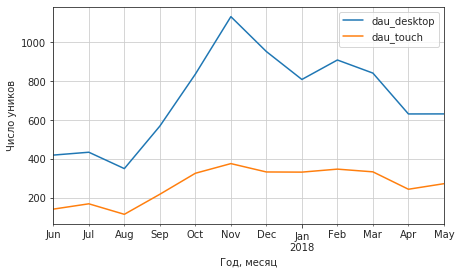


 Метрики: ['wau_desktop', 'wau_touch'] 


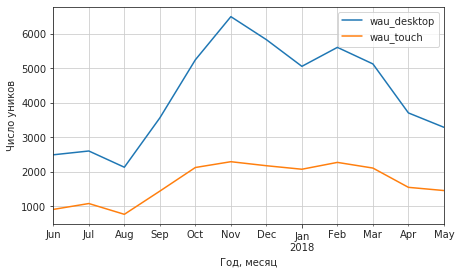


 Метрики: ['mau_desktop', 'mau_touch'] 


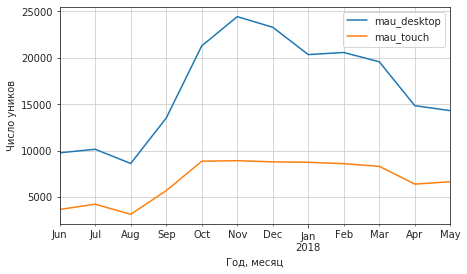


 Метрики: ['sticky_wau_desktop', 'sticky_wau_touch'] 


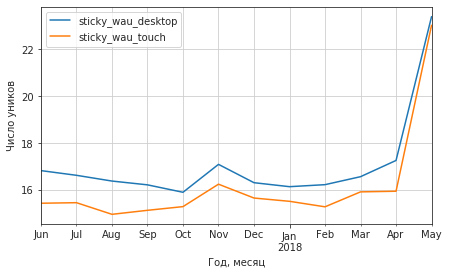


 Метрики: ['sticky_mau_desktop', 'sticky_mau_touch'] 


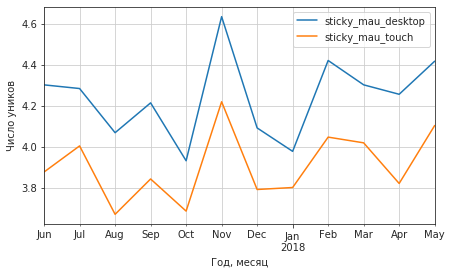

In [21]:
# Сформируем лист метрик
metrics = [['dau_desktop','dau_touch'],['wau_desktop','wau_touch'], ['mau_desktop','mau_touch'],
           ['sticky_wau_desktop','sticky_wau_touch'], ['sticky_mau_desktop','sticky_mau_touch']]

# Напишем цикл для создания диаграмм для каждой пар метрик
for i in metrics:
    print('\033[1m Метрики:', i,'\033[0m')
    visits_metrics.pivot_table(i,
                     index=['month_r'], aggfunc='mean').plot(figsize=(7,4))
    plt.xlabel('Год, месяц')
    plt.ylabel('Число уников')
    plt.grid(True)
    plt.show()
    print('')

Тренд на десктопных и на мобильных устройствах был в целом одинаков. DAU, WAU и MAU в период с августа по ноябрь росли и затем падали вплоть до мая на обоих устройствах, однако прирост новых пользователей с десктопных устройств был больше.

In [22]:
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
dau = visits.groupby('day').agg({'uid': 'nunique'}).mean()

print('mau =', int(mau))
print('wau =', int(wau))
print('dau =', int(dau))

mau = 23227
wau = 5716
dau = 907


In [23]:
sticky_wau = dau / wau * 100
sticky_mau = dau / mau * 100

print('sticky_wau: {:.2f}'.format(sticky_wau.mean()), '%')
print('sticky_mau: {:.2f}'.format(sticky_mau.mean()), '%')

sticky_wau: 15.88 %
sticky_mau: 3.91 %


На Яндекс.Афишу в среднем в день заходит 907 уникальных пользователей, 5716 в неделю и 23227 в месяц.<br>
Sticky factor отношения числа уников в день к числу уников в неделю равняется 15.88%, а к числу уников в месяц 3.91%. Это не самые высокие показатели лояльности аудитории, но и не самые низкие. Можно сделать вывод, что пользователи Яндекс.Афиши редко полсещают ее каждый день или каждую неделю.

###  <i> Продукт. Сколько сессий в день? </i>

In [24]:
# Будем считать среднее по когортам
sessions_per_user = visits.groupby(['year', 'day']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

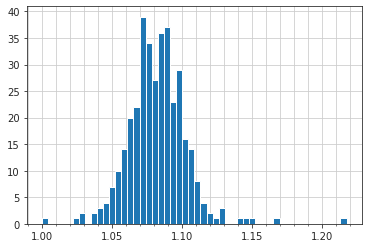

In [25]:
sessions_per_user['sess_per_user'].hist(bins=50)

Распределение близко к нормальному, посмотрим на среднее.

In [26]:
print('Сессий в день: {:.2f}'.format(sessions_per_user['sess_per_user'].mean()))

Сессий в день: 1.08


В среднем, пользователи Яндекс.Афиши проводят 1.08 на сервисе сессий в день.

### <i> Продукт. Сколько длится одна сессия? </i>

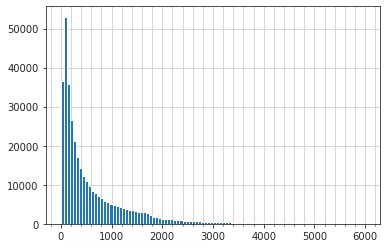

In [27]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['session_duration_sec'].hist(bins=100, range=(0, 6000))

Распределение переменной скорей напоминает распределение Пуассона, а не нормальное, поэтому будет корретнее посчитать медиану.<p>
Стоит отметить, что некоторое число сессий длится 0 секунд. Без дополнительных сведений о причинах данного явления не будем исключать эти данные из анализа.

In [28]:
print('Сессия обычно длится:', int(visits['session_duration_sec'].median()/60), 'минут')

Сессия обычно длится: 5 минут


Обычно сессия на Яндекс.Афише длится 5 минут.

### <i> Продукт. Как часто люди возвращаются? </i>

In [29]:
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,day,day_r,month_r,week_r,mau,wau,dau,sticky_wau,sticky_mau,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,20,2017-12-01,2017-12-14,8785,2006,275,15.60239,3.790464,1080
1,touch,2017-12-20 18:53:00,3,2017-12-20 18:50:00,15499483512161066509,2017,12,51,2017-12-20,20,2017-12-01,2017-12-14,8785,2006,275,15.60239,3.790464,180
2,touch,2017-12-20 14:37:00,4,2017-12-20 14:33:00,16600447022660362147,2017,12,51,2017-12-20,20,2017-12-01,2017-12-14,8785,2006,275,15.60239,3.790464,240
3,touch,2017-12-20 20:56:00,5,2017-12-20 20:56:00,8742720214579951303,2017,12,51,2017-12-20,20,2017-12-01,2017-12-14,8785,2006,275,15.60239,3.790464,0
4,touch,2017-12-20 17:10:00,2,2017-12-20 17:07:00,413959372896270046,2017,12,51,2017-12-20,20,2017-12-01,2017-12-14,8785,2006,275,15.60239,3.790464,180


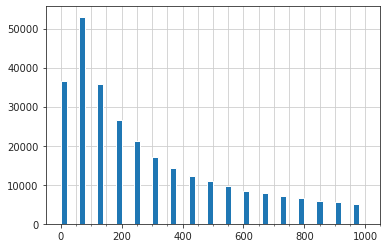

In [30]:
visits['session_duration_sec'].hist(bins=50,range=(0,1000))

In [31]:
visits['session_duration_sec'].value_counts().sort_index()

0        35794
19         868
60       53029
120      35748
180      26672
         ...  
32880        1
35760        1
42660        1
83640        1
84480        1
Name: session_duration_sec, Length: 312, dtype: int64

In [32]:
# Сосдадим переменную первого посещения
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

In [33]:
# Сформируем когорты по месяцам
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['visits_month'] = visits['day'].astype('datetime64[M]')

In [34]:
# Рассчитаем lifetime пользователей
visits['cohort_lifetime'] = visits['start_ts'] - visits['first_activity_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)

In [35]:
# Подсчитаем для каждой когорты количество активных пользователей на каждый месяц
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
 
# Найдем исходное количество пользователей на нулевую неделю
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
 
# Переименуем столбец
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [36]:
# Объединение данных по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
 
#Рассчитаем RR
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

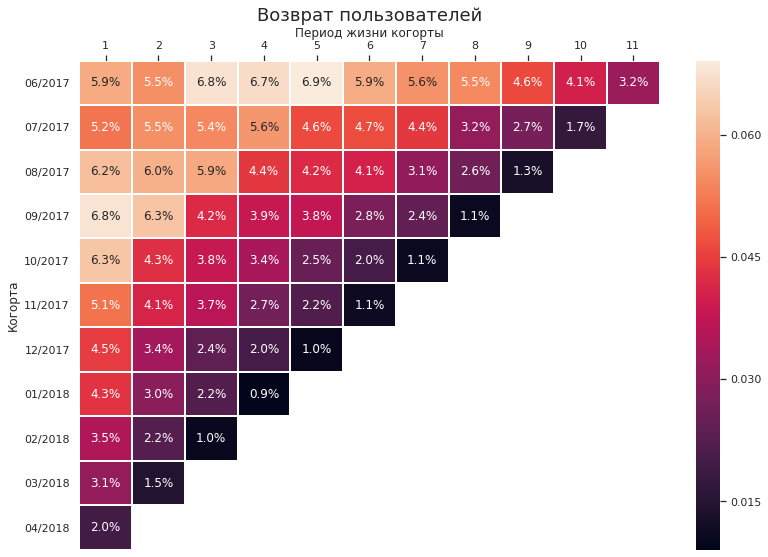

In [37]:
matplotlib.rcParams['xtick.minor.visible'] = False

# Сводная таблица для построения тепловой карты
retention_pivot = cohorts[(cohorts['cohort_lifetime'] > 0) & (cohorts['first_activity_month'] < '2018-05-01')
                         ].pivot_table(index='first_activity_month',columns='cohort_lifetime',
                                      values='retention',aggfunc='sum')
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
retention_pivot

# Тепловая карта
sns.set(style='white')
plt.figure(figsize=(13, 9))

ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white')

plt.title('Возврат пользователей', fontsize= 18)
plt.ylabel('Когорта')
plt.xlabel('Период жизни когорты')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

Процент возврата на сайта низкий и колеблется от 0.9% до 6.9% в зависимости от когорты и месяца. Первые когорты были более лояльны, чем последние: у них заметен больший % возврата (5-6% в первые месяцы против 3-2% у когорт начиная с декабря 2017. Лояльность новых клиентов в 2018 году хуже аналогичной в 2017 году. Из интересного можно выделить высокую посещаемость в августе-октябре 2017г, когда процентр возврата пользователей из разных когорт находился на уровне 6%. Возможно, этому предшествовала успешная рекламная кампания.

### <i> Продажи. Когда люди начинают покупать? </i>

In [38]:
# Добавим в таблицу ordres колнку с датой первой активнсти
visits_orders = orders.merge(first_activity_date, on = 'uid')
visits_orders.head()

,buy_ts,revenue,uid,first_activity_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


In [39]:
# Найдем день первой покупки и добавим в таблицу visits_orders
first_order_date = visits_orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
visits_orders = visits_orders.merge(first_order_date, on = 'uid')

In [40]:
# Сгрупперуем по uid и найдем разницу между первым заходом и первой покупкой в минутах
first_buy_time = visits_orders.groupby('uid').agg({'first_order_date': 'min','first_activity_date': 'min'}).reset_index()
first_buy_time['first_buy_time'] = ((first_buy_time['first_order_date'] - first_buy_time['first_activity_date']) /
                           pd.Timedelta(1, unit='m')).astype(int)

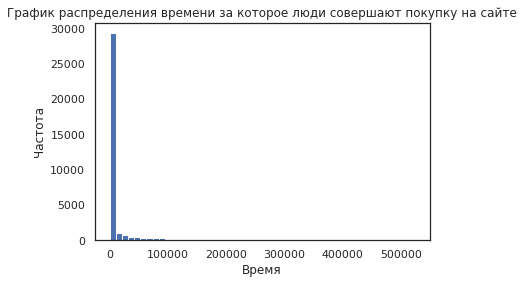

In [41]:
# Построим график распределения
plt.hist(first_buy_time['first_buy_time'], bins=50)
plt.title('График распределения времени за которое люди совершают покупку на сайте')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

Распределение совершенно не похоже на нормальное, отчати напоминает Пуассоновское. Поэтому вычислим медиану вместо среднего.

In [42]:
print('Люди совершают покупку как правило через {:.0f} минут.'
      .format(first_buy_time['first_buy_time'].median()))

Люди совершают покупку как правило через 16 минут.


На Яндекс.Афише люди совершают покупку как правило через 16 минут с момента захода на сервис.

### <i> Продажи. Сколько раз покупают за период? </i>

In [43]:
# Длбавим в таблицу orders дату и месяц первой покупки и месяц покупи
orders = orders.merge(first_order_date, on = 'uid')

orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [44]:
# Посчитаем кол-во заказов, покупателей и сумарную выручку
orders_cohorts = (orders.groupby(['first_order_month','order_month'])
                        .agg({'uid':['nunique','count'], 'revenue': 'sum'})
                        .reset_index())

orders_cohorts.columns = ['first_order_month','order_month','buyers_cnt','orders_cnt','revenue_sum']

In [45]:
# Выделим периоды когорт равные месяцу
orders_cohorts['cohort_lifetime'] = ((orders_cohorts['order_month'] - orders_cohorts['first_order_month']) / 
                                      np.timedelta64(1,'M')).round().astype(int)

In [46]:
# Добавим столбец с изначальным кол-ом покупателей в каждой когорте
initial_buyers_count = orders_cohorts[orders_cohorts['cohort_lifetime'] == 0][['first_order_month', 'buyers_cnt']]
initial_buyers_count = initial_buyers_count.rename(columns = {'buyers_cnt': 'cohort_buyer_cnt'})

orders_cohorts = orders_cohorts.merge(initial_buyers_count, on='first_order_month')

In [47]:
# Считаем сколько покупок приходится на одного покупателя
orders_cohorts['order_per_user'] = orders_cohorts['orders_cnt'] / orders_cohorts['buyers_cnt']
order_per_user_pivot = orders_cohorts.pivot_table(index = 'first_order_month',columns = 'cohort_lifetime',
                                                  values = 'order_per_user', aggfunc = 'mean')

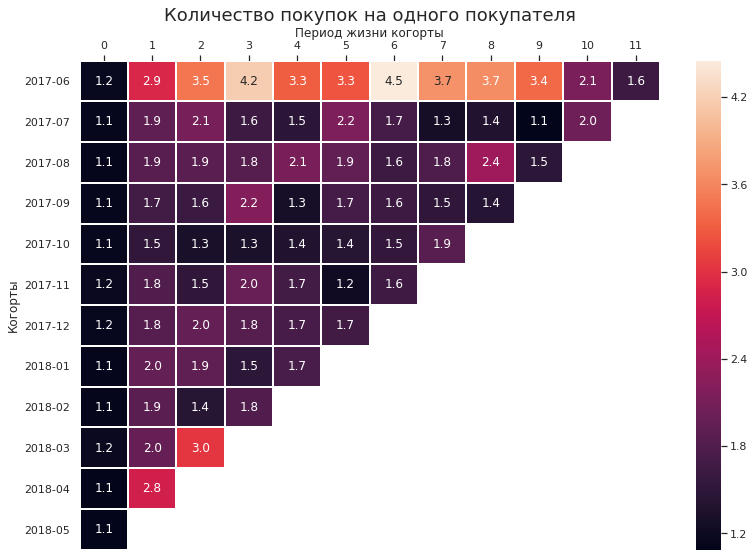

In [48]:
#sns.set(style='white')
matplotlib.rcParams['xtick.minor.visible'] = False

plt.figure(figsize=(13, 9))
plt.title('Количество покупок на одного покупателя', fontsize= 18)

ax = sns.heatmap(order_per_user_pivot,annot=True,fmt='.1f', linewidths=1,linecolor='white')

plt.xlabel('Период жизни когорты')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_yticklabels(order_per_user_pivot.index.strftime('%Y-%m'))
plt.ylabel('Когорты')

plt.show()

Количество покупок на одного пользователя колеблется от 1.1 до 4.5 в зависимости от когорты и месяца покупки. Первая когорта выделяется на фоне других. Люди из ее числа совершают в среднем 3 покупки на человека, тогда как для других когорт этот показатель скорее близок к 1.7. В последний месяц (май 2018) когорты 2018-03 и 2018-04 совершили значительно больше покупок, чем обычно: 3.0 и 2.8 на человека соответственно. Возможно, к этому привела маркетинговая кампания, направленная на удержание новых пользователей (если таковая была).

### <i> Продажи. Какой средний чек? </i>

In [49]:
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [50]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [51]:
orders_pivot_revenue = orders.query('revenue > 0').pivot_table(index='first_order_month',columns='order_month',
                                                               values='revenue', aggfunc='mean')
orders_pivot_revenue

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,4.061832,5.547006,5.177427,8.621875,7.108522,6.825321,6.966449,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,NaN,5.289542,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302
2017-08-01,NaN,NaN,4.718557,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478
2017-09-01,NaN,NaN,NaN,4.970498,13.231606,8.351056,62.570244,15.430448,15.321835,16.923832,11.206607,7.785574
2017-10-01,NaN,NaN,NaN,NaN,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.384381,4.166931,4.474670,6.284976,4.441471,3.726780,4.598235
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.115634,4.226741,20.072772,26.084358,15.948488,14.111048
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687417,4.438482,6.454969,7.524844,2.711282
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.707171,4.576486,3.453735,3.867143


In [52]:
orders_revenue_pivot = orders.query('revenue > 0').pivot_table(index='order_month',
    values='revenue',
    aggfunc='mean')
orders_revenue_pivot.index = orders_revenue_pivot.index.strftime("%m/%Y")
orders_revenue_pivot = orders_revenue_pivot.reset_index()
orders_revenue_pivot.columns = ['order_month', 'revenue']
orders_revenue_pivot

,order_month,revenue
0,06/2017,4.061832
1,07/2017,5.308836
2,08/2017,4.857892
3,09/2017,5.422852
4,10/2017,4.930016
5,11/2017,4.796231
6,12/2017,5.863455
7,01/2018,4.112927
8,02/2018,4.841011
9,03/2018,5.414946


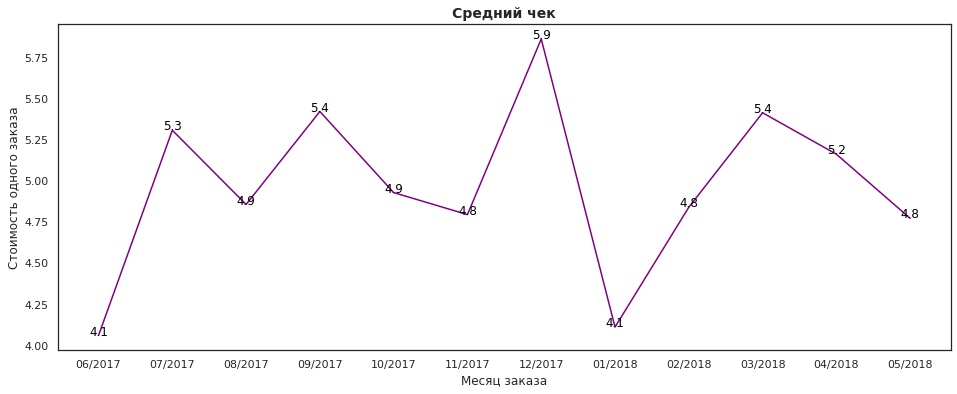

In [53]:
fig, ax = plt.subplots(figsize=(16, 6))

g = sns.lineplot(x='order_month', y='revenue', data=orders_revenue_pivot, color='purple',sort = False, ax=ax)

# Добавим подписи данных
for index, row in orders_revenue_pivot.iterrows():
    g.text(index, row['revenue'], round(row['revenue'],1), color='black', ha="center")

    
plt.title('Средний чек', weight='bold').set_fontsize('14')
plt.xlabel('Месяц заказа')
plt.ylabel('Стоимость одного заказа')
plt.show()

Средний чек колебался от 4.1 до 5.9 у.е. в зависимости от месяца. Тренд относительно стабильный, но бывают взлеты и падения. Так, в июня 2017 и январе 2018 наблюдалось падение среднего чека до 4.1 у.е., а в декабре 2017 - повышение до 5.9 у.е. Динамику в декабре-январе можно объяснить покупкой подарков перед новым годом и дальнейшая пауза в покупках.

### <i> Продажи. Сколько денег приносят? (LTV) </i>

In [54]:
# Так как в условии задачи маржинальность не указана, установим ее равную 0.5
margin_rate = 0.5

In [55]:
# Посчитаем валовую прибыль и сколько в среднем приносит один клиент за месяц
orders_cohorts['gp'] = orders_cohorts['revenue_sum'] * margin_rate
orders_cohorts['ltv'] = orders_cohorts['gp'] / orders_cohorts['cohort_buyer_cnt']

In [56]:
ltv_pivot = orders_cohorts.pivot_table(index = 'first_order_month',columns = 'cohort_lifetime',values = 'ltv',
                                       aggfunc = 'mean')

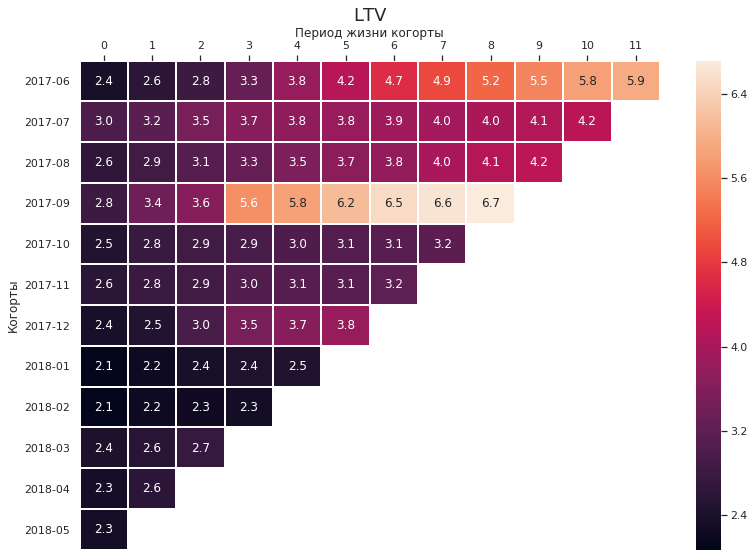

In [57]:
#sns.set(style='white')
matplotlib.rcParams['xtick.minor.visible'] = False

plt.figure(figsize=(13, 9))
plt.title('LTV', fontsize= 18)


ax = sns.heatmap(ltv_pivot.cumsum(axis=1),annot=True,fmt='.1f', linewidths=1, linecolor='white')

plt.xlabel('Период жизни когорты')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_yticklabels(order_per_user_pivot.index.strftime('%Y-%m'))
plt.ylabel('Когорты')

plt.show()

Первая когорта показала хорошие результаты выручки: LTV к 11 месяцу жизни составило 5.9 у.е. Вторая и треться когорта также были успешны, но менее, чем первая: к 10 и 9 годам жизни их LTV составил 4.2 у.е. Четвертая когорта была самой успешной и по итогу 8 месяцев обогнала даже первую когорту (которая уже на 11 месяце) в LTV, который составил 6.7 у.е. Наименее успешны когорты 2018-01 и 2018-04: на всех месяцах своей жизни они приносили наименьшую прибыль в сравнении с другими когортами. Новые когорты 2018-03, 2018-04 и 2018-05 начали чуть более успешно, чем их предшественники. Это тенденция к улучшению показателя LTV.

### <i> Маркетинг. Сколько денег потратили? Всего / на каждый источник / по времени </i>

In [58]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [59]:
# По какой-то странной причине для номеров источников рекламных кампаний не строился график seaborn. По совету наставника применила
# эту функцию и все стало ок. 
costs['source_id_hack'] = ["$%s$" % x for x in costs["source_id"]]

In [60]:
costs.head()

,source_id,dt,costs,month,source_id_hack
0,1,2017-06-01,75.20,2017-06-01,$1$
1,1,2017-06-02,62.25,2017-06-01,$1$
2,1,2017-06-03,36.53,2017-06-01,$1$
3,1,2017-06-04,55.00,2017-06-01,$1$
4,1,2017-06-05,57.08,2017-06-01,$1$


In [61]:
costs['source_id'].value_counts().sort_index()

1     363
2     363
3     363
4     363
5     364
9     363
10    363
Name: source_id, dtype: int64

In [62]:
print('Всего на маркетинг потрачено:', costs['costs'].sum())

Всего на маркетинг потрачено: 329131.62


In [63]:
costs_source_pivot = costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
costs_source_pivot = costs_source_pivot.reset_index()
costs_source_pivot

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [64]:
costs_source_pivot['source_id_hack'] = ["$%s$" % x for x in costs_source_pivot["source_id"]]
costs_source_pivot

,source_id,costs,source_id_hack
0,1,20833.27,$1$
1,2,42806.04,$2$
2,3,141321.63,$3$
3,4,61073.60,$4$
4,5,51757.10,$5$
5,9,5517.49,$9$
6,10,5822.49,$10$


In [65]:
costs_source_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
source_id         7 non-null int64
costs             7 non-null float64
source_id_hack    7 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 296.0+ bytes


In [66]:
costs_pivot = costs.pivot_table(index='month',columns='source_id_hack', values='costs', aggfunc='sum')
costs_pivot

source_id_hack,$1$,$10$,$2$,$3$,$4$,$5$,$9$
month,,,,,,,
2017-06-01,1125.61,314.22,2427.38,7731.65,3514.80,2616.12,285.22
2017-07-01,1072.88,329.82,2333.11,7674.37,3529.73,2998.14,302.54
2017-08-01,951.81,232.57,1811.05,6143.54,3217.36,2185.28,248.93
2017-09-01,1502.01,460.67,2985.66,9963.55,5192.26,3849.14,415.62
2017-10-01,2315.75,627.24,4845.00,15737.24,6420.84,5767.40,609.41
2017-11-01,2445.16,792.36,5247.68,17025.34,5388.82,6325.34,683.18
2017-12-01,2341.20,645.86,4897.80,16219.52,7680.47,5872.52,657.98
2018-01-01,2186.18,614.35,4157.74,14808.78,5832.79,5371.52,547.16
2018-02-01,2204.48,480.88,4474.34,14228.56,5711.96,5071.31,551.50


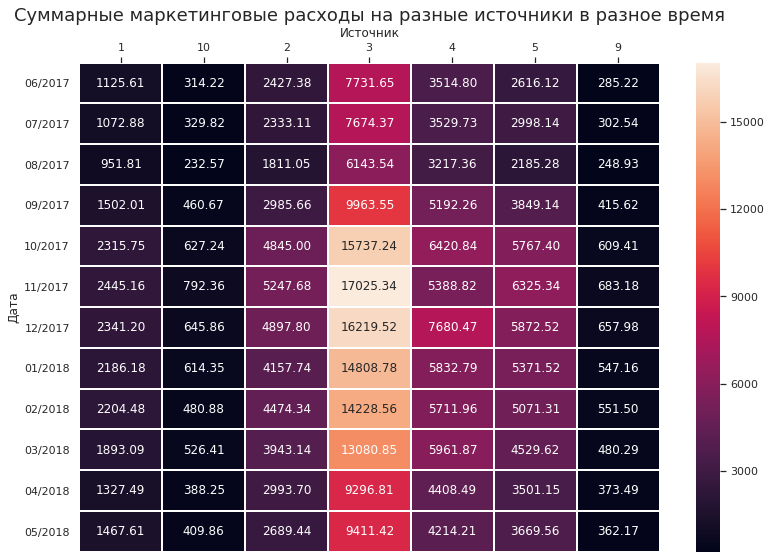

In [67]:
matplotlib.rcParams['xtick.minor.visible'] = False

costs_pivot.index = costs_pivot.index.strftime("%m/%Y")

plt.figure(figsize=(13, 9))
ax = sns.heatmap(costs_pivot, annot=True, fmt='.2f', linewidths=1, linecolor= 'white')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title('Суммарные маркетинговые расходы на разные источники в разное время', fontsize=18)
plt.xlabel('Источник')
plt.ylabel('Дата')

plt.show()

In [68]:
print('Распределение суммарных трат на маркетинг по источникам')
costs_pivot2 = costs.pivot_table(index='source_id_hack', values='costs', aggfunc='sum')
costs_pivot2.sort_values('costs', ascending=False)

Распределение суммарных трат на маркетинг по источникам


,costs
source_id_hack,
$3$,141321.63
$4$,61073.60
$5$,51757.10
$2$,42806.04
$1$,20833.27
$10$,5822.49
$9$,5517.49


In [70]:
# costs_pivot.month.unique()

In [71]:
# Только так смогла нормально подписать графики, через .strftime("%m/%Y") не вышло
normal_months_list = ['2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
       '2018-02', '2018-03', '2018-04', '2018-05']
normal_months_list

['2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05']

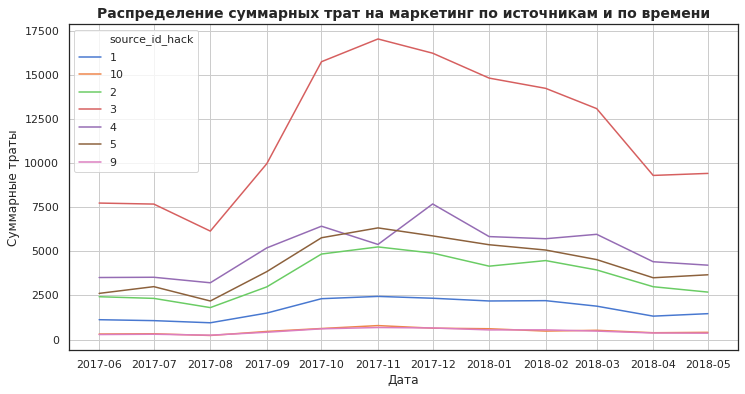

In [72]:
matplotlib.rcParams['axes.grid'] = False
costs_pivot = costs.pivot_table(index=['month','source_id_hack'], values='costs', aggfunc='sum').reset_index()

g = sns.lineplot(x='month', y='costs', hue='source_id_hack', palette='muted',data=costs_pivot)

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.title('Распределение суммарных трат на маркетинг по источникам и по времени', weight='bold').set_fontsize('14')
plt.xlabel('Дата')
plt.ylabel('Суммарные траты')

g.set_xticks(normal_months_list)
g.set_xticklabels(normal_months_list)

plt.grid()
plt.show()

На источники было потрачено от 248.93 у.е. до 17025.34 у.е. в зависимости от типа источника и месяца. Самый дорогой источник - третий: на него стабильно тратилось больше средств в сравнеии с другими источниками, а общая сумма составила 141321 у.е. Следующими по дороговизне стали 4, 5 и 2 источники: на них было потрачено суммарно 61073 у.е., 51757 у.е. и 42806 у.е. соответственно. Далее идет 1 источник с общими тратами 20833 у.е. Самыми бюджетными оказались 10 и 9 источники, на которые было потрачено 5822 у.е. и 5517 у.е.<p>
Для некоторых источников (2,4,5,3, 10, 9) время с октября 2017 по март 2018 стало периодом повышенных трат, особенно это касается источника 3, чьи расходы выросли в 1.5 раза.

### <i> Маркетинг. Сколько стоило привлечение одного покупателя из каждого источника? </i>

In [73]:
costs['source_id_hack'] = ["$%s$" % x for x in costs["source_id"]]

In [74]:
visits['source_id_hack'] = ["$%s$" % x for x in visits["source_id"]]

In [75]:
# Узнаем из какого источника был первый визит и сколько пользователй из него пришли
first_visits_source = visits.sort_values(by = ['start_ts'], ascending = True).groupby('uid').agg(
                                                    {'source_id_hack': 'first', 'month_r': 'first'}).reset_index()

# Получим таблицу, состояющую из уникальных id пользователей, совершивших заказ на сайте
orders['month_r'] = orders['buy_ts'].astype('datetime64[M]')
orders_uid = orders.groupby('uid').agg({'revenue':'first', 'month_r': 'first'}).reset_index()
del orders_uid['revenue']

# Оставим пересечение двух таблиц (нам нужно узнать источник, с которого пришел покупатель), сгруппируем по типу источника
first_visits_source = pd.merge(first_visits_source, orders_uid, how = 'inner', on = 'uid')
del first_visits_source['month_r_x']
first_visits_source.columns = ['uid', 'source_id_hack', 'month_r']
first_visits_source = first_visits_source.groupby(['month_r',  'source_id_hack']).agg({'uid': 'count'})
first_visits_source

uid
month_r    source_id_hack     
2017-06-01 $1$             190
           $10$             95
           $2$             235
           $3$             638
           $4$             413
...                        ...
2018-05-01 $2$             412
           $3$             844
           $4$             804
           $5$             497
           $9$              60

[85 rows x 1 columns]

In [76]:
# Сгруппируем расходы на маркетинг по источнику и месяцу
costs['month_r'] = costs['dt'].astype('datetime64[M]')
costs_source_pivot = costs.pivot_table(index=['month_r','source_id_hack'], values='costs', aggfunc='sum').reset_index()
costs_source_pivot

,month_r,source_id_hack,costs
0,2017-06-01,$1$,1125.61
1,2017-06-01,$10$,314.22
2,2017-06-01,$2$,2427.38
3,2017-06-01,$3$,7731.65
4,2017-06-01,$4$,3514.80
...,...,...,...
79,2018-05-01,$2$,2689.44
80,2018-05-01,$3$,9411.42
81,2018-05-01,$4$,4214.21
82,2018-05-01,$5$,3669.56


In [77]:
# Объединяем с таблицей расходов на рекламные источники
cac = pd.merge(first_visits_source, costs_source_pivot, how = 'left', on = ['month_r','source_id_hack'])
cac.rename(columns = {'uid': 'users_count'}, inplace = True)
cac

,month_r,source_id_hack,users_count,costs
0,2017-06-01,$1$,190,1125.61
1,2017-06-01,$10$,95,314.22
2,2017-06-01,$2$,235,2427.38
3,2017-06-01,$3$,638,7731.65
4,2017-06-01,$4$,413,3514.80
...,...,...,...,...
80,2018-05-01,$2$,412,2689.44
81,2018-05-01,$3$,844,9411.42
82,2018-05-01,$4$,804,4214.21
83,2018-05-01,$5$,497,3669.56


In [78]:
# Уберем наблюдение с одним привлеченным пользователем из источника 7
cac = cac.drop(cac[cac['users_count'] == 1].index)
cac.reset_index(drop=True, inplace=True)

In [79]:
# Считаем CAC. Делим затраты на каждый источник на кол-во пришедхих пользователей по этому источнику.
cac['cac'] = cac['costs'] / cac['users_count']

In [80]:
cac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 5 columns):
month_r           84 non-null datetime64[ns]
source_id_hack    84 non-null object
users_count       84 non-null int64
costs             84 non-null float64
cac               84 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.4+ KB


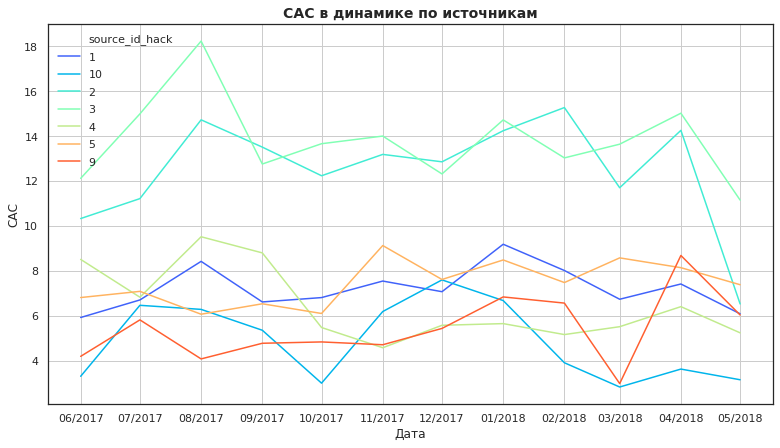

In [94]:
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['xtick.minor.visible'] = False


cac_pivot = cac.pivot_table(index=['month_r','source_id_hack'], values='cac', aggfunc='sum').reset_index()

g = sns.lineplot(x='month_r', y='cac', hue='source_id_hack', palette='rainbow',data=cac_pivot, legend = 'full')

fig = plt.gcf()
fig.set_size_inches(13, 7)

g.set_xticks(normal_months_list)
g.set_xticklabels(normal_months_list)

plt.title('CAC в динамике по источникам', weight='bold').set_fontsize('14')
plt.xlabel('Дата')
plt.ylabel('CAC')

plt.legend(loc='upper left', frameon=False)

plt.grid(True)
plt.show()

В целом, в показателях CAC по источникам и месяцах не прослеживается четкого тренда.<p>
CAC 3 и 2 источника самые крупные и колеблятся от от 10 до 15 у.е., при этом в мае 2019 года оба показателя заметно снизились: 3 источник до 11, 3 источник до 6.5 у.е.<br>
CAC 5 источника колебался в течение года в пределах 7-9 у.е., при этом можно говорить о едва заметном восходящем тренде.<br>
CAC 4 источника также менялся от месяца к месяцу, снизившись с 8.3 у.е. в июне 2017 до 5.2 у.е. в мае 2018<br>
1 и 10 источники имели значительное повышение CAC в период зимних праздников: 10 источник резко вырос до 7.8 у.е. в декабре, а 1 - до 9 у.е. в январе, и затем обе категории упали. CAC 1 источника колебался в меньших пределах, чем CAC 10 источника: 6-7.2 у.е. против 2.8-7.8 у.е. соответственно, при этом к весне 2018 CAC 10 источника держался на своем минимальном уровне.<br>
CAC 9 источника находился в пределах от 3 до 8.8 у.е., наблюдалось резкое падаение в марте до своего годового минимуму, после чего последовал резкий рост в апреле, достигнув годового максимума.<br>

In [93]:
cac_pivot.month_r.dt.strftime("%m/%Y").unique()

array(['06/2017', '07/2017', '08/2017', '09/2017', '10/2017', '11/2017',
       '12/2017', '01/2018', '02/2018', '03/2018', '04/2018', '05/2018'],
      dtype=object)

In [82]:
cac_groupped = cac.groupby('source_id_hack').agg({'cac': 'sum', 'users_count':'sum'}).reset_index()
cac_groupped

,source_id_hack,cac,users_count
0,$1$,86.545286,2899
1,$10$,58.405501,1329
2,$2$,150.048815,3506
3,$3$,165.632917,10473
4,$4$,77.272488,10295
5,$5$,89.423257,6931
6,$9$,64.966699,1088


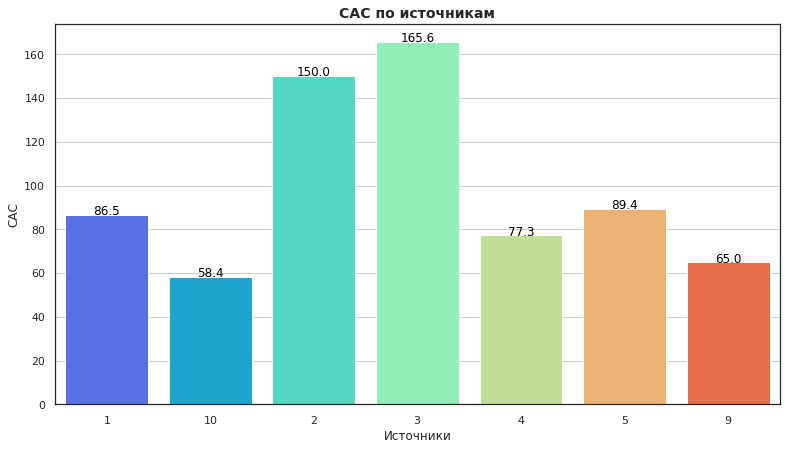

In [83]:
matplotlib.rcParams['axes.grid'] = False

fig, ax = plt.subplots(figsize=(13, 7))

g = sns.barplot(x='source_id_hack', y='cac', data=cac_groupped, palette='rainbow',ax=ax)

# Добавим подписи данных
for index, row in cac_groupped.iterrows():
    g.text(index, row['cac'], round(row['cac'],1), color='black', ha="center")
    

plt.title('CAC по источникам', weight='bold').set_fontsize('14')
plt.xlabel('Источники')
plt.ylabel('CAC')
ax.yaxis.grid(True)
plt.show()

Третий источник был самым дорогим, но стоимость привлечения нового клиента посредсвом этого источника оказалась одной из самых худших (165 у.е.), в эту же группу попал источник 2 со средней стоимостью 152 у.е. за нового клиента. Самый впечатляющий CAC оказался у 10 источника, он тратит на каждого клиента по 56 у.е. 1, 4, 5 и 9 источники также показалис хороший результат: их CAC равняется 87, 74, 92 и 92 у.е. соответственно.

### <i> Маркетинг. На сколько окупились расходы? (ROI) </i>

In [84]:
# В данном случае наверное все же имеется ввиду возврат маркетинговых расходов (ROMI), a не возврат инвестиций (ROI) 

In [85]:
costs_group_month =(costs.groupby('month').agg({'costs': 'sum'}).reset_index())

In [86]:
# Добавляем расходы на рекламу по месяцам
orders_cohorts = orders_cohorts.merge(costs_group_month, left_on = 'first_order_month', right_on = 'month')

In [87]:
orders_cohorts['cac'] = orders_cohorts['costs'] / orders_cohorts['cohort_buyer_cnt']
orders_cohorts['romi'] = orders_cohorts['ltv'] / orders_cohorts['cac']

In [88]:
romi_pivot = orders_cohorts.pivot_table(index = 'first_order_month',columns = 'cohort_lifetime',
                                        values = 'romi', aggfunc = 'mean')

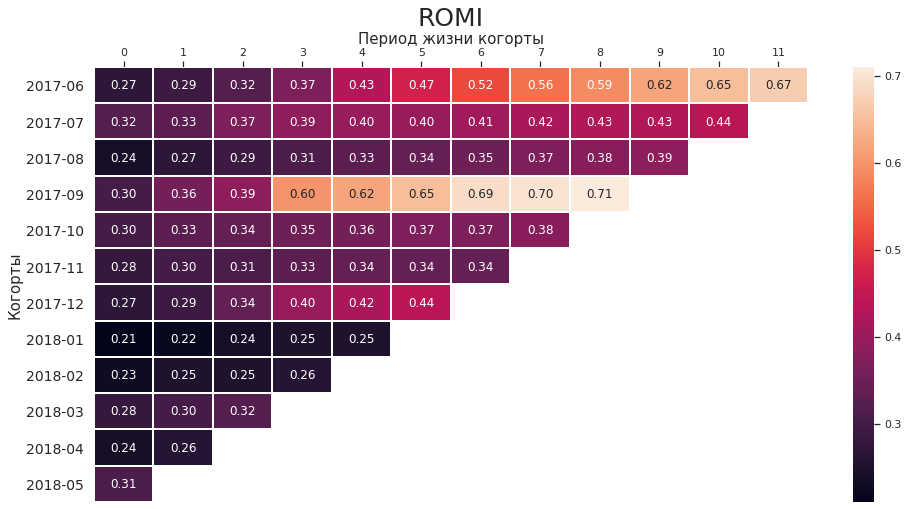

In [89]:
matplotlib.rcParams['xtick.minor.visible'] = False

plt.figure(figsize=(16, 8))
plt.title('ROMI', fontsize= 25)
              
ax = sns.heatmap(romi_pivot.cumsum(axis=1).round(2),annot=True, fmt='.2f', linewidths=1, linecolor='white')


plt.xlabel('Период жизни когорты',fontsize=15) 
plt.xticks(fontsize= 14)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.ylabel('Когорты',fontsize=15)
plt.yticks(fontsize= 14)
ax.set_yticklabels(ltv_pivot.index.strftime('%Y-%m'))

plt.show()

При установленной маржинальности 50% ни одна из когорт пока не окупилась. В среднем, отметки в 50% окупаемости (или 100% при margin rate = 1.0) когорты достигают к 8 месяцу. Наиболе успешна в этом 4 когорта, которая к 8 месяцу жизни достигла показателя в 71% и 1 когорта, которая к 11 месяцу достигда отметки в 67%.

### Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам, также как они меняются во времени.

Маркетинговые метрики уже были изображены на графиках с распределением по рекламным источникам и по времени.
Средний чек, LTV, маркетинговые расходы, CAC и ROMI задействуют в своих расчетах таблицу с заказами, в которой отстутствует
распределение по устройствам. Мы не можем знать, с какого устройства был совершен заказ. Также из общих знаний о digital среде
мы знаем, что люди часто комбинируют заходы на сайт как с ПК, так и с мобильных устройств. Поэтому честных данных об этих
метриках с разбивкой по устройствам мы предоставить не можем. Будет лучше показать обычное распределение заходов на сайт 
по устройствам.

In [90]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
visits_by_device

,uid
device,
desktop,262559
touch,96829


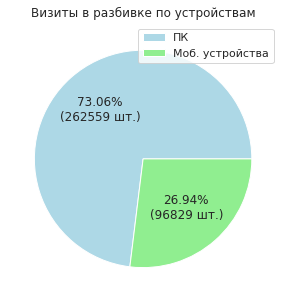

In [91]:
# Добавим на график проценты
def func_pct(pct):
    value = float(pct/100.*visits_by_device.values.sum())
    return "{:.2f}%\n({:.0f} шт.)".format(pct, value)

visits_pie = visits_by_device.plot(kind='pie', y='uid', use_index=False,
                        title = 'Визиты в разбивке по устройствам',figsize=(15,5), 
                        autopct=lambda pct: func_pct(pct), colors=['lightblue', 'lightgreen'], labels=None)
legend = visits_pie.legend(['ПК', 'Моб. устройства'])
y_label = visits_pie.set_ylabel('')

Большинство пользователей (73%) заходили на сайт Яндекс.Афиши с компьютера, смартфон для этой цели использовали 27%.

## Шаг 3. Вывод. Порекомендовать маркетологам, куда и сколько им стоит вкладывать средств.

#### На основе данных о посещениях, покупках с сайта Яндекс.Афиша и расходов на маркетинг во второй половине 2017 года - первой половине 2018 года были получены следующие результаты:
<p>
<b><u>Пользование</b></u>
<br>
<li>На Яндекс.Афишу в среднем в день заходит 907 уникальных пользователей, 5716 в неделю и 23227 в месяц. Sticky factor отношения числа уников в день к числу уников в неделю равняется 15.88%, а к числу уников в месяц 3.91%. Это не самые высокие показатели лояльности аудитории, но и не самые низкие. Можно сделать вывод, что пользователи Яндекс.Афиши редко посещают ее каждый день или каждую неделю.
<br>
<li>В динамике метрики посещаемости (dau, wau, mau) с июня по август были относительно стабильны, далее демонстрировали резкий рост, достигали вершины в ноябре и к маю медленно снижались. Так, число уникальных полизователей, заходивших на сайт Яндекс.Афиши в июне 2017 составило 8 тыс., к ноябрю равнялось уже 20 тыс., к маю снизилось до 12 тыс. Для wau показатели в эти месяцы были 2.1 тыс., 5.4 тыс., 2.7тыс. Для dau: 350, 943, 527. Показатели sticky wau и sticky mau были стабильны практически весь год. Наблюдался едва заметный всплеск в ноябре и в период с апрель по мая sticky wau резко вырос с 16.9 до 23.3
<br>
<li>Тренд на десктопных и на мобильных устройствах был в целом одинаков. DAU, WAU и MAU в период с августа по ноябрь росли и затем падали вплоть до мая на обоих устройствах, однако прирост новых пользователей с десктопных устройств был больше.  
<br>
<li>Процент возврата на сайта низкий и колеблется от 0.9% до 6.9% в зависимости от когорты и месяца. Первые когорты были более лояльны, чем последние: у них заметен больший % возврата (5-6% в первые месяцы против 3-2% у когорт начиная с декабря 2017. Лояльность новых клиентов в 2018 году хуже аналогичной в 2017 году. Из интересного можно выделить высокую посещаемость в августе-октябре 2017г, когда процентр возврата пользователей из разных когорт находился на уровне 6%. Возможно, этому предшествовала успешная рекламная кампания.
<br>
<li>В среднем, пользователи Яндекс.Афиши проводят 1.08 на сервисе сессий в день.
<br>
<li>Cессия обычно длится 5 минут.
<br>
<li>Большинство пользователей (73%) заходили на сайт с компьютера, смартфон для этой цели использовали 27%.
<p>
<b><u>Покупки</b></u>
<br>
<li>На Яндекс.Афише люди совершают покупку как правило через 16 минут с момента захода на сервис.
<br>
<li>Количество покупок на одного пользователя колеблется от 1.1 до 4.5 в зависимости от когорты и месяца покупки. Первая когорта выделяется на фоне других. Люди из ее числа совершают в среднем 3 покупки на человека, тогда как для других когорт этот показатель скорее близок к 1.7. В последний месяц (май 2018) когорты 2018-03 и 2018-04 совершили значительно больше покупок, чем обычно: 3.0 и 2.8 на человека соответственно. Возможно, к этому привела маркетинговая кампания, направленная на удержание новых пользователей (если таковая была).
<br>
<li>Средний чек колебался от 4.1 до 5.9 у.е. в зависимости от месяца. Тренд относительно стабильный, но бывают взлеты и падения. Так, в июня 2017 и январе 2018 наблюдалось падение среднего чека до 4.1 у.е., а в декабре 2017 - повышение до 5.9 у.е. Динамику в декабре-январе можно объяснить покупкой подарков перед новым годом и дальнейшая пауза в покупках.
<p>
<b><u>LTV</b></u>
<br>
<li>Первая когорта показала хорошие результаты выручки: LTV к 11 месяцу жизни составило 5.9 у.е. Вторая и треться когорта также были успешны, но менее, чем первая: к 10 и 9 годам жизни их LTV составил 4.2 у.е. Четвертая когорта была самой успешной и по итогу 8 месяцев обогнала даже первую когорту (которая уже на 11 месяце) в LTV, который составил 6.7 у.е. Наименее успешны когорты 2018-01 и 2018-04: на всех месяцах своей жизни они приносили наименьшую прибыль в сравнении с другими когортами. Новые когорты 2018-03, 2018-04 и 2018-05 начали чуть более успешно, чем их предшественники. Это тенденция к улучшению показателя LTV.
<p>
<b><u>Расходы на маркетинг</b></u>
<br>
<li>На рекламные источники было потрачено от 248.93 у.е. до 17025.34 у.е. в зависимости от типа источника и месяца. Самый дорогой источник - третий: на него стабильно тратилось больше средств в сравнеии с другими источниками, а общая сумма составила 141321 у.е. Следующими по дороговизне стали 4, 5 и 2 источники: на них было потрачено суммарно 61073 у.е., 51757 у.е. и 42806 у.е. соответственно. Далее идет 1 источник с общими тратами 20833 у.е. Самыми бюджетными оказались 10 и 9 источники, на которые было потрачено 5822 у.е. и 5517 у.е. Для некоторых источников (2,4,5,3, 10, 9) время с октября 2017 по март 2018 стало периодом повышенных трат, особенно это касается источника 3, чьи расходы выросли в 1.5 раза.
<br>
<li>В целом, тренд расходов на маркетинг восходящий: к весне 2018 года на рекламу и продвижение тратили больше, чем осенью 2017. Больше всего возросли суммы, которые вкладывали в источник 9. Траты на источник 2 увеличивались постепенно, но в мае 2018 резко сократились. Аналогичное произошло с источником 3 и источником 10, который начал снижаться еще в апреле. Другие источники к маю либо остались на том же уровне, либо выросли. Из интересного, в декабре наблюдался резкое повышение трат на источник 10, а в марте - резкое снижение на источник 9.
<br>
<li>Третий источник был самым дорогим, но стоимость привлечения нового клиента посредсвом этого источника оказалась одной из самых худших (165 у.е.), в эту же группу попал источник 2 со средней стоимостью 152 у.е. за нового клиента. Самый впечатляющий CAC оказался у 10 источника, он тратит на каждого клиента по 56 у.е. 1, 4, 5 и 9 источники также показали хороший результат: их CAC равняется 87, 74, 92 и 92 у.е. соответственно.
<br>
<li>В целом, в показателях CAC по источникам и месяцах не прослеживается четкого тренда.<p>
CAC 3 и 2 источника самые крупные и колеблятся от от 10 до 15 у.е., при этом в мае 2019 года оба показателя заметно снизились: 3 источник до 11, 3 источник до 6.5 у.е.<br>
CAC 5 источника колебался в течение года в пределах 7-9 у.е., при этом можно говорить о едва заметном восходящем тренде.<br>
CAC 4 источника также менялся от месяца к месяцу, снизившись с 8.3 у.е. в июне 2017 до 5.2 у.е. в мае 2018<br>
1 и 10 источники имели значительное повышение CAC в период зимних праздников: 10 источник резко вырос до 7.8 у.е. в декабре, а 1 - до 9 у.е. в январе, и затем обе категории упали. CAC 1 источника колебался в меньших пределах, чем CAC 10 источника: 6-7.2 у.е. против 2.8-7.8 у.е. соответственно, при этом к весне 2018 CAC 10 источника держался на своем минимальном уровне.<br>
CAC 9 источника находился в пределах от 3 до 8.8 у.е., наблюдалось резкое падаение в марте до своего годового минимуму, после чего последовал резкий рост в апреле, достигнув годового максимума.<br>
<p>
<b><u>ROMI</b></u>
<br>
<li>При установленной маржинальности 50% ни одна из когорт пока не окупилась. В среднем, отметки в 50% окупаемости (или 100% при margin rate = 1.0) когорты достигают к 8 месяцу. Наиболе успешна в этом 4 когорта, которая к 8 месяцу жизни достигла показателя в 71% и 1 когорта, которая к 11 месяцу достигда отметки в 67%.

#### Рекомендации:<p>
<li><u>Не все когорты были одинаково успешными.</u> Первая когорта (2017-06) имела высокие показатели количества покупок на человека (3), высокий LTV (5.9 за 11 месяцев жизни). Четвертая когорта (2017-09) не отличалась средним числом покупок, но отличалась LTV (6.7 за 8 месяцев жизни). Вместе они составляли категорию наиболее близких к окупаемости когорт (67% и 71% соответственно). Когорты 2018-01 и 2018-02 демонстрировали более низкое число покупок, самое низкое LTV (2.5 и 2.3 соответственно) и самые низкие показатели ROMI (25% на 3 месяце и 26% на 4 месяце соответственно). Имеет смысл проанализировать отличия когорт друг от друга. Возможно, когорты были сформированы силами крупных маркетинговых кампаний, которые тарегтировались на разную целевую аудиторию или же использовала разные инсайты, техники. Подход, применимый к получаению 1 и 4 когорт следует масштабировать на будущие.
<p>
<li><u>Также отличались между собой результаты инвестиций в разные рекламные источники.</u> Траты на 3 источник были максимальными и составили 141 тыс. у.е., когда как этот источник показывал весьма посредственный CAC по сравнению с другими. 10 источник был наиболее экономичным по цене (56 у.е) за привлечение нового пользователя, CAC 1, 4, 5 и 9 источников также находился на хорошем уровне. Будет правильным сконцентрироваться на 10 источнике, но также не забывать про 1, 4, 5 и 9 направления. На 9 и 10 источники предлагаем потратить значительно больше средств, чем было сделано в прошлом году.